In this notebook, I will build a simple chatbot using LangGraph that can initiate conversations, integrate external tools, and retain conversation history.

Install dependencies

In [1]:
!pip3 install langgraph typing_extensions

To get started with building the chatbot, the first thing we need to do is initialize a state graph. A state graph is a core concept in LangGraph that models the flow of a conversation as a state machine — a system where different 'states' represent different stages in a process.

In our case, each state is defined by a node. A node can be anything from a simple Python function, a call to a language model (LLM), or an integration with an external tool (like a calculator or a web search API). These nodes define the individual operations or logic that the chatbot performs.

Once we define the nodes, we connect them using edges, which specify how the conversation should transition from one node to another based on the current input or output. This structure allows us to build flexible, dynamic workflows where the chatbot can respond intelligently, call tools when needed, and maintain memory across interactions.

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages

Creating a graph using stategraph

In [3]:
class State(TypedDict):
    """State for the graph."""
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)


Install langchain aws so that we can connect all the models hosted in AWS bedrock

In [4]:
pip install -U "langchain[aws]"

Note: you may need to restart the kernel to use updated packages.


The previous step initialized a new graph builder. Now, we can begin creating nodes and connecting them with edges, allowing the chatbot to transition between different stages or functions.

To define a new node, we create a Python function that accepts the current state as input. This state includes the latest data from the conversation. The function performs its specific task—such as generating a response or calling a tool—and then returns an updated state.

Within the function, you'll write the logic needed to handle that part of the conversation. Once the task is completed, the state is modified to include any new messages or data, which can then be used by the next node in the graph.

In [5]:
from langchain.chat_models import init_chat_model
model = init_chat_model("anthropic.claude-3-5-sonnet-20240620-v1:0", model_provider="bedrock_converse")
def chatbot(state: State) -> State:
    """Chatbot function to handle messages."""
    # response = model.invoke(state["messages"])
    # print(response)
    # state["messages"].append(response)
    # return state
    return {"messages": [model.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)


After defining a node, the next step is to add edges to connect it within the graph. These edges determine the path the bot will follow, enabling it to execute each function by visiting all relevant nodes.

LangGraph provides a default START state, so it's essential to link this start state to the first node that should be executed in the flow.

Once all nodes have been defined and properly connected with edges, we compile the graph builder. This generates a graph object, which acts as the final executable workflow and can be used to run or query the chatbot.

In [6]:
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

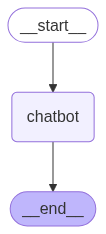

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

At this point, the graph has been fully constructed with all the necessary nodes and edges, meaning our agent is ready to run. We can now start interacting with it by sending in questions or messages.

In [8]:
def stream_graph_responses(user_input: str):
    """Stream responses from the graph."""
    state = {"messages": [{"role": "user", "content": user_input}]}
    for response in graph.stream(state):
        print(response,"response bfore iterating values")
        for value in response.values():
            print(value)
            print("Assistant :", value["messages"][-1].content,end="")

In [9]:
user_input = "Give me a short description of the Eiffel Tower in one line."    
stream_graph_responses(user_input)


{'chatbot': {'messages': [AIMessage(content='Iconic 984-foot iron lattice tower in Paris, built in 1889, symbolizing French engineering and culture.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '3ebe6353-72ea-4dab-85aa-f278d7755402', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 26 Jun 2025 02:45:24 GMT', 'content-type': 'application/json', 'content-length': '284', 'connection': 'keep-alive', 'x-amzn-requestid': '3ebe6353-72ea-4dab-85aa-f278d7755402'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [993]}, 'model_name': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run--15e25a21-6d08-4c30-9056-21889ca114d2-0', usage_metadata={'input_tokens': 23, 'output_tokens': 29, 'total_tokens': 52, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}} response bfore iterating values
{'messages': [AIMessage(content='Iconic 984-foot iron lattice tower in Paris, built in 1889, symbolizing French engineering and culture.',

At this stage, we have a working chatbot that can receive queries from a user and pass them to a basic language model for generating responses. While this setup mirrors a standard LLM-based assistant, the key advantage of our chatbot lies in its extensibility. Unlike a basic model interaction, this chatbot can invoke multiple models or tools, making it far more powerful and adaptable.

We can integrate external tools to expand its capabilities—such as performing web or Google searches, accessing internal company systems like communication platforms, databases, or application logs, and executing any custom logic we implement. This transforms the chatbot from a simple Q&A interface into a smart agent capable of real operational tasks.

For example, imagine a scenario where a user inputs: 'Robin, one of our long-time customers with SSN ###-##-####, is planning to apply for another loan. What offers can we provide?'

In this case, the chatbot can extract the customer's SSN using a language model, then use a pre-built tool to call an internal API with that SSN to retrieve personalized offers. The chatbot automatically performs this sequence—understanding the query, extracting the required data, calling the tool, and returning a meaningful response.

Now that we’ve built the foundation, let’s shift focus to integrating external tools into our chatbot workflow.